# Plant seedling recognition

Classification process will consist of next steps:
1. [Get data](#section1) — reading of images and labels
2. [Cleaning data](#section2) — removing of image background, input normalization and label preparatin
3. [Model](#section3) — creating training and validation sets, creating and fitting model
4. [Evaluate model](#section4) — evaluation of model, make prediction


<a id='section1'></a>
## 1. Get data

Obtaining images and resizing to 70 x 70 px. We use a 70 x 70 px size for a quicker training of model. Also here we get image labels from folder name

In [1]:
import cv2
from glob import glob
import numpy as np
from matplotlib import pyplot as plt
import math
import pandas as pd

ScaleTo = 70  # px to scale
seed = 7  # fixing random

path = '../input/plant-seedlings-classification/train/*/*.png' 
files = glob(path)

trainImg = []
trainLabel = []
j = 1
num = len(files)

# Obtain images and resizing, obtain labels
for img in files:
    print(str(j) + "/" + str(num), end="\r")
    trainImg.append(cv2.resize(cv2.imread(img), (ScaleTo, ScaleTo)))  # Get image (with resizing)
    trainLabel.append(img.split('/')[-2])  # Get image label (folder name)
    j += 1

trainImg = np.asarray(trainImg)  # Train images set
trainLabel = pd.DataFrame(trainLabel)  # Train labels set

Let's look at some examples of plant photos

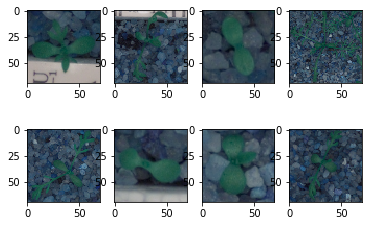

In [2]:
# Show some example images
for i in range(8):
    plt.subplot(2, 4, i + 1)
    plt.imshow(trainImg[i])

As we can see, every photo of plant seedling has an background, so let's try to remove it. It'll help us to goal better model accuracy

<a id='section2'></a>
## 2. Cleaning data

For removing the background, we'll use the fact, that all plants on our photos are green. We can create a mask, which will leave some range of green color and remove other part of image.

### 2.1. Masking green plant 
For creating mask, which will remove background, we need to convert RGB image to HSV. HSV is alternative of the RGB color model. In HSV, it is easier to represent a color range than in RGB color space.

![HSV color model](https://codewords.recurse.com/images/six/image-processing-101/hsv.png)

Besides of this, we'll blur image firstly for removing noise. After creating HSV image, we'll create mask based on empirically selected range of green color, convert it to boolean mask and apply it to the origin image.

* Use gaussian blur for remove noise
* Convert color to HSV
* Create mask
* Create boolean mask
* Apply boolean mask and getting image whithout background

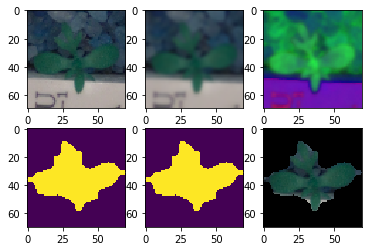

In [3]:
clearTrainImg = []
examples = []; getEx = True
for img in trainImg:
    # Use gaussian blur
    blurImg = cv2.GaussianBlur(img, (5, 5), 0)   
    
    # Convert to HSV image
    hsvImg = cv2.cvtColor(blurImg, cv2.COLOR_BGR2HSV)  
    
    # Create mask (parameters - green color range)
    lower_green = (25, 40, 50)
    upper_green = (75, 255, 255)
    mask = cv2.inRange(hsvImg, lower_green, upper_green)  
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11, 11))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    # Create bool mask
    bMask = mask > 0  
    
    # Apply the mask
    clear = np.zeros_like(img, np.uint8)  # Create empty image
    clear[bMask] = img[bMask]  # Apply boolean mask to the origin image
    
    clearTrainImg.append(clear)  # Append image without backgroung
    
    # Show examples
    if getEx:
        plt.subplot(2, 3, 1); plt.imshow(img)  # Show the original image
        plt.subplot(2, 3, 2); plt.imshow(blurImg)  # Blur image
        plt.subplot(2, 3, 3); plt.imshow(hsvImg)  # HSV image
        plt.subplot(2, 3, 4); plt.imshow(mask)  # Mask
        plt.subplot(2, 3, 5); plt.imshow(bMask)  # Boolean mask
        plt.subplot(2, 3, 6); plt.imshow(clear)  # Image without background
        getEx = False

clearTrainImg = np.asarray(clearTrainImg)

Good result! Let's look at other examples of masked images 

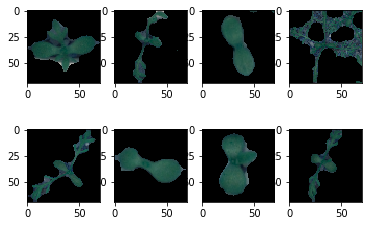

In [4]:
# Show sample result
for i in range(8):
    plt.subplot(2, 4, i + 1)
    plt.imshow(clearTrainImg[i])

As we can see, we removed most of the background.

### 2.2. Normalize input

Now set the values of input from [0...255] to [0...1] (RGB color-space encode colors with numbers [0...255]). CNN will be faster train if we use [0...1] input

In [5]:
clearTrainImg = clearTrainImg / 255

### 2.3. Categories labels

Now we encode image labels. Labels are 12 string names, so we could create classes array with this names, for example ['Black-grass' 'Charlock' 'Cleavers' 'Common Chickweed' 'Common wheat' 'Fat Hen' 'Loose Silky-bent' 'Maize' 'Scentless Mayweed' 'Shepherds Purse' 'Small-flowered Cranesbill' 'Sugar beet'] and encode every label by position in this array. For example 'Charlock' -> [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0].

We need to encode all labels in this way.

Using TensorFlow backend.


Classes: ['Black-grass' 'Charlock' 'Cleavers' 'Common Chickweed' 'Common wheat'
 'Fat Hen' 'Loose Silky-bent' 'Maize' 'Scentless Mayweed' 'Shepherds Purse'
 'Small-flowered Cranesbill' 'Sugar beet']
Number of classes: 12


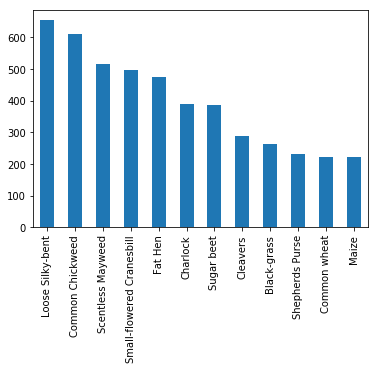

In [6]:
from keras.utils import np_utils
from sklearn import preprocessing
import matplotlib.pyplot as plt

# Encode labels and create classes
le = preprocessing.LabelEncoder()
le.fit(trainLabel[0])
print("Classes: " + str(le.classes_))
encodeTrainLabels = le.transform(trainLabel[0])

# Make labels categorical
clearTrainLabel = np_utils.to_categorical(encodeTrainLabels)
num_clases = clearTrainLabel.shape[1]
print("Number of classes: " + str(num_clases))

# Plot of label types numbers
trainLabel[0].value_counts().plot(kind='bar')

As we can see, we have different counts of images of different species. So, data is unbalanced

<a id='section3'></a>
## 3. Model

### 3.1. Split dataset
Split data on training and validation set. 10% of data became the validation set

Our data is unbalanced, so for avoide inaccurate evaluation of model set stratify=clearTrainLabel

In [7]:
from sklearn.model_selection import train_test_split

trainX, testX, trainY, testY = train_test_split(clearTrainImg, clearTrainLabel, 
                                                test_size=0.1, random_state=seed, 
                                                stratify = clearTrainLabel)

### 3.2. Data generator
To avoide overfitting we need to create image generator which will randomly rotate, zoom, shift and flip image during the fitting of the model.

* Set random rotation from 0 to 180 degrees
* Set random zoom at 0.1
* Set random shifting at 0.1
* Set horisontal and vertical flips

In [8]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
        rotation_range=180,  # randomly rotate images in the range
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally
        height_shift_range=0.1,  # randomly shift images vertically 
        horizontal_flip=True,  # randomly flip images horizontally
        vertical_flip=True  # randomly flip images vertically
    )  
datagen.fit(trainX)

### 3.3. Create model

For creation model i used Keras Sequential.

I created model with six convolutional layers and three fully-connected layers in the end. First two convolutional layers have 64 filters, next 128 filters and the last two layers have 256 filters. After each pair of convolution layers model have max pooling layer. Also, to reduce overfitting after each pair of convolution layers we use dropout layer (10% between convolutional layers and 50% between fully connect layers) and between each layer we use batch normalization layer. 

In the end i used three fully-connected layers for classifing. In the last layer the neural net outputs destribution of probability for each of 12 classes. 

In [9]:
import numpy
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers import BatchNormalization

numpy.random.seed(seed)  # Fix seed

model = Sequential()

model.add(Conv2D(filters=64, kernel_size=(5, 5), input_shape=(ScaleTo, ScaleTo, 3), activation='relu'))
model.add(BatchNormalization(axis=3))
model.add(Conv2D(filters=64, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization(axis=3))
model.add(Dropout(0.1))

model.add(Conv2D(filters=128, kernel_size=(5, 5), activation='relu'))
model.add(BatchNormalization(axis=3))
model.add(Conv2D(filters=128, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization(axis=3))
model.add(Dropout(0.1))

model.add(Conv2D(filters=256, kernel_size=(5, 5), activation='relu'))
model.add(BatchNormalization(axis=3))
model.add(Conv2D(filters=256, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization(axis=3))
model.add(Dropout(0.1))

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(num_clases, activation='softmax'))

model.summary()

# compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 66, 66, 64)        4864      
_________________________________________________________________
batch_normalization_1 (Batch (None, 66, 66, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 62, 62, 64)        102464    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 64)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 31, 31, 64)        256       
_________________________________________________________________
dropout_1 (Dropout)          (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 27, 27, 128)       204928    
__________

### 3.4. Fit model
Here we'll train our model. Firstly, we set several callbacks. First callback reduce model learning rate. With high learning rate model quiker is the convergance, however with high learning rate the model could fall into a local minimum. So, we will decreace the learning rate at the process of fitting. We will reduce learning rate if the accuracy is not improved after for three epoch. Other two callbacks save best and last weights of model.

We won't train model on kaggle kernel, becauce it is too long process, so i comment the lines of code with fitting.

In [10]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger

# learning rate reduction
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.4, 
                                            min_lr=0.00001)

# checkpoints
filepath="drive/DataScience/PlantReco/weights.best_{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', 
                             verbose=1, save_best_only=True, mode='max')
filepath="drive/DataScience/PlantReco/weights.last_auto4.hdf5"
checkpoint_all = ModelCheckpoint(filepath, monitor='val_acc', 
                                 verbose=1, save_best_only=False, mode='max')

# all callbacks
callbacks_list = [checkpoint, learning_rate_reduction, checkpoint_all]

# fit model
# hist = model.fit_generator(datagen.flow(trainX, trainY, batch_size=75), 
#                            epochs=35, validation_data=(testX, testY), 
#                            steps_per_epoch=trainX.shape[0], callbacks=callbacks_list)

<a id='section4'></a>
## 4. Evaluate model
### 4.1. Load model from file

Here we load the weights of best-fitting model from file (i used kaggle dataset with weights of model, which i trained earlier). Also i load from Data.npz training and validation data sets, on which model was fitting for evaluating of model accuracy.

In [11]:
model.load_weights("../input/plantrecomodels/weights.best_17-0.96.hdf5")

data = np.load("../input/plantrecomodels/Data.npz")
d = dict(zip(("trainX","testX","trainY", "testY"), (data[k] for k in data)))
trainX = d['trainX']
testX = d['testX']
trainY = d['trainY']
testY = d['testY']

print(model.evaluate(trainX, trainY))  # Evaluate on train set
print(model.evaluate(testX, testY))  # Evaluate on test set

4275/4275 [==============================] - 146s 34ms/step
[0.0014231697897974949, 0.99953216374269005]
475/475 [==============================] - 17s 35ms/step
[0.27398812518308036, 0.96210526353434511]


### 4.2. Confusion matrix

A good way to look at model errors.

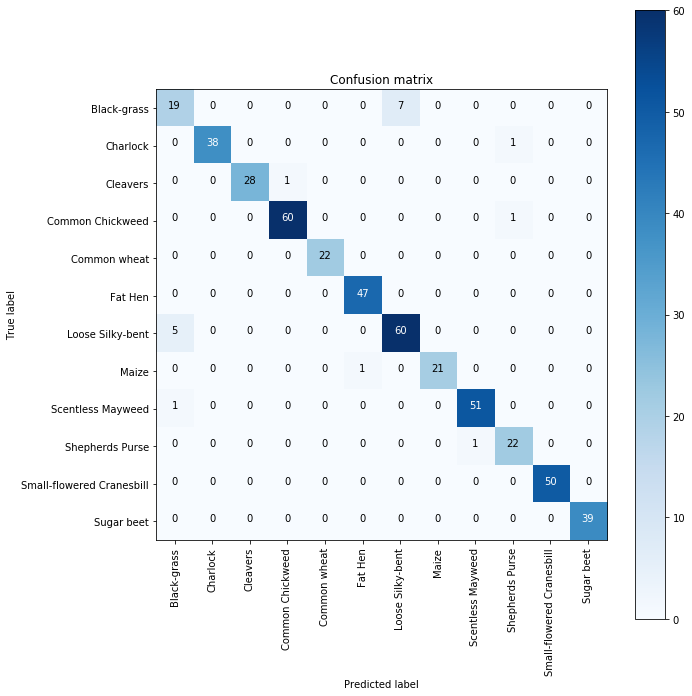

In [12]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    fig = plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
predY = model.predict(testX)
predYClasses = np.argmax(predY, axis = 1) 
trueY = np.argmax(testY, axis = 1) 

# confusion matrix
confusionMTX = confusion_matrix(trueY, predYClasses) 

# plot the confusion matrix
plot_confusion_matrix(confusionMTX, classes = le.classes_) 

### 4.3. Get results

And finnaly we get the result of prediction on test data.

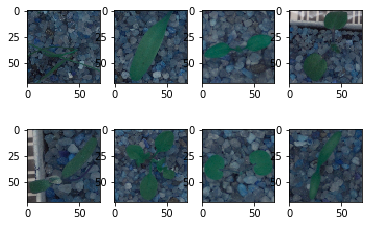

In [13]:
path = '../input/plant-seedlings-classification/test/*.png'
files = glob(path)

testImg = []
testId = []
j = 1
num = len(files)

# Obtain images and resizing, obtain labels
for img in files:
    print("Obtain images: " + str(j) + "/" + str(num), end='\r')
    testId.append(img.split('/')[-1])  # Images id's
    testImg.append(cv2.resize(cv2.imread(img), (ScaleTo, ScaleTo)))
    j += 1

testImg = np.asarray(testImg)  # Train images set

for i in range(8):
    plt.subplot(2, 4, i + 1)
    plt.imshow(testImg[i])

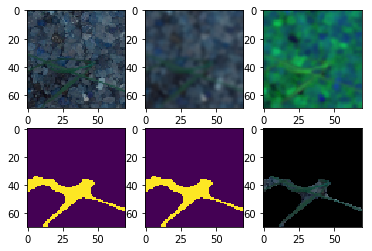

In [14]:
clearTestImg = []
examples = []; getEx = True
for img in testImg:
    # Use gaussian blur
    blurImg = cv2.GaussianBlur(img, (5, 5), 0)   
    
    # Convert to HSV image
    hsvImg = cv2.cvtColor(blurImg, cv2.COLOR_BGR2HSV)  
    
    # Create mask (parameters - green color range)
    lower_green = (25, 40, 50)
    upper_green = (75, 255, 255)
    mask = cv2.inRange(hsvImg, lower_green, upper_green)  
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11, 11))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    # Create bool mask
    bMask = mask > 0  
    
    # Apply the mask
    clear = np.zeros_like(img, np.uint8)  # Create empty image
    clear[bMask] = img[bMask]  # Apply boolean mask to the origin image
    
    clearTestImg.append(clear)  # Append image without backgroung
    
    # Show examples
    if getEx:
        plt.subplot(2, 3, 1); plt.imshow(img)  # Show the original image
        plt.subplot(2, 3, 2); plt.imshow(blurImg)  # Blur image
        plt.subplot(2, 3, 3); plt.imshow(hsvImg)  # HSV image
        plt.subplot(2, 3, 4); plt.imshow(mask)  # Mask
        plt.subplot(2, 3, 5); plt.imshow(bMask)  # Boolean mask
        plt.subplot(2, 3, 6); plt.imshow(clear)  # Image without background
        getEx = False

clearTestImg = np.asarray(clearTestImg)

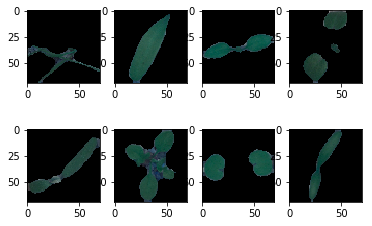

In [15]:
# Show sample result
for i in range(8):
    plt.subplot(2, 4, i + 1)
    plt.imshow(clearTestImg[i])

In [16]:
clearTestImg = clearTestImg / 255

In [17]:
pred = model.predict(clearTestImg)

In [18]:
# Write result to file
predNum = np.argmax(pred, axis=1)
predStr = le.classes_[predNum]

res = {'file': testId, 'species': predStr}
res = pd.DataFrame(res)
res.to_csv("res.csv", index=False)